### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [ ]:
#!pip install numdifftools

### Solution

In [344]:
#import things
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from scipy.stats import laplace
import corner
import numdifftools as nd

In [305]:
#1
#read in the data
data=np.load('../../../homeworks/hw_data/hw3_data_1.npy')
#slice array
values=data[:,0]
error=data[:,1]
#mean and se from formula in lecture 5
wm = np.sum((1 / (error** 2)) * values) / np.sum((1 / (error** 2))) #mean
wse= (np.sum((1 / (error** 2)))) ** (-1/2) #standard error
print("mean",wm,"and standard error",wse)

mean 3.917992034606056 and standard error 0.09481084100510954


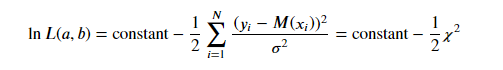

In [418]:
#2 
#likelyhood from lecture 6
#creating a log likelyhood funciton from above 
def log_likely(mu, x, dx):
    return np.sum(((x - mu) / (2 * dx)) ** 2 - (1 / np.sqrt(2 * np.pi * dx))) #contains gauss constant with negative

# getting our fsquared 
f_squared = lambda beta: log_likely(beta[0], x=values, dx=error)
#optimizing likelyhood
beta0 = (3,.1) #guess at mean and sd
beta_squared = optimize.fmin(f_squared, beta0)
print( "mean is",beta_squared)

Optimization terminated successfully.
         Current function value: -16.763014
         Iterations: 53
         Function evaluations: 106
mean is [3.91799204 0.09220013]


In [412]:
#chi^2
#checking out the chi squared 
N=len(values)
A=(1/(N-1))
chi_squared=A*np.sum((values-m)**2/(error**2))
print("data","chi^2=",round(chi_squared,2))

data chi^2= 0.87


In [308]:
#3 From lecture 5 fisher uncertainty estimate
xgrid=np.linspace(1,6,100)
L = norm.pdf(xgrid,loc=wm,scale=wse)
sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu=np.abs(sigma_mu) #need this for code to work?
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.095


In [320]:
#4 bootstraping 
def bootstrap(data1, num_samples):
    indices = np.random.randint(0, 50, size=(num_samples, 50)) #pick out some of the samples and their error
    bootstrap_samples = data1[indices] # Using indices to select bootstrap samples
    return bootstrap_samples
# Generate 1000 draws from our data
boots= bootstrap(data,1000)

In [463]:
#5 
#repeating part 2 with boots
boot_means = [] # means

# getting means
for sample in boots: 
    x = sample[:, 0]  # values
    dx = sample[:, 1]  # errors
    boot_likely = lambda beta: log_likelihood(beta[0], x, dx) 
    #optimizing
    beta0 = x[0]
    beta_squared = optimize.fmin(boot_likely, beta0,disp=False) 
    boot_means.append(beta_squared[0])

(3.5, 4.5)

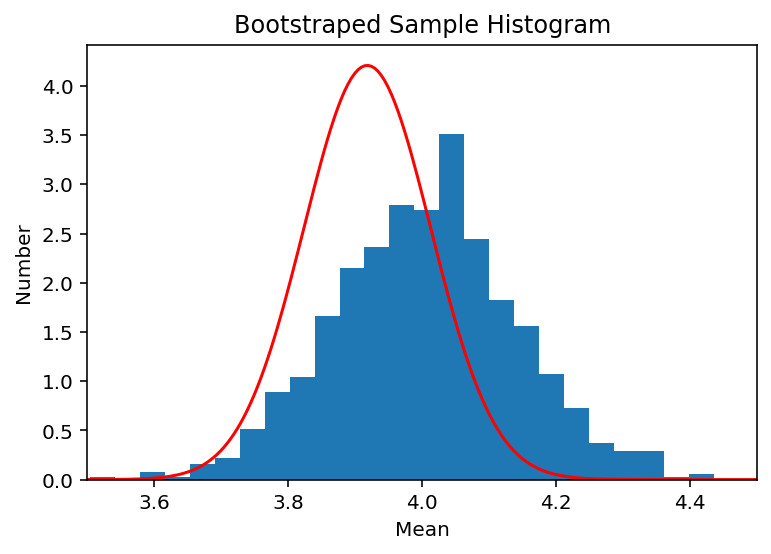

In [464]:
#plotting

plt.hist(boot_means, bins=25, density=True)
plt.title("Bootstraped Sample Histogram")
plt.xlabel('Mean')
plt.ylabel('Number')

xgrid=np.linspace(0,5,1000)
pdf = norm.pdf(xgrid, loc=wm, scale=wse)
plt.plot(xgrid, pdf,color='red')
plt.xlim(3.5,4.5)


The bootstraps and hist do not agree

In [454]:
#6 Trying laplace ln likelyhood

# following form from step 4
def laplace_likely(mu, x, dx):
    return -1 * np.sum(laplace.logpdf(x, loc=mu, scale=dx))

# getting the f funciton
f_lnlaplace = lambda beta: laplace_likely(mu=beta[0], x=values, dx=error)

# optimizing
beta0 = (3.5,.1)
beta_laplace = optimize.fmin(f_lnlaplace, beta0)

print("The mean is", beta_laplace)

Optimization terminated successfully.
         Current function value: 157.201616
         Iterations: 87
         Function evaluations: 164
The mean is [4.04294769 0.0864265 ]


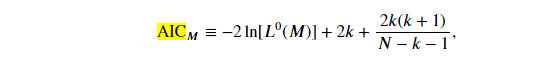

In [471]:
#7 AIC

N= 50 #number of values
k_lap = 2 # laplacian k value
k_gauss = 1 #gauss k value


a=-log_likely(mu=beta[0], x=values, dx=error)
b=-laplace_likely(mu=beta[0], x=values, dx=error)
# AIC from the formula above
def AIC(Like, k, N):
    return (2 * k) - (2 * Like) + ((2 * k * (k + 1)) / (N - k - 1))

print("AIC for the Gaussian", AIC(a, k_gauss, N))
print("AIC for the Laplacian", AIC(b, k_lap, N))

AIC for the Gaussian -21.724400134084977
AIC for the Laplacian 335.71092317154347


Gauss favored

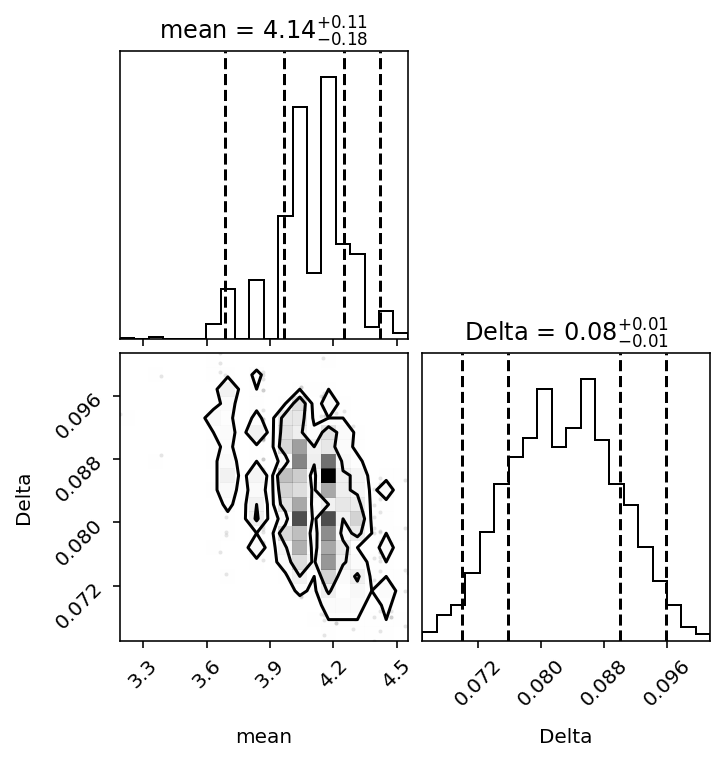

In [460]:
#8 more boots
boots_lapmean = [] #means
boots_laperror = [] #error

# get all the means and errors
for sample in boots: 
    x = sample[:, 0]  
    dx = sample[:, 1]  
    boot_laplike = lambda beta: laplace_likely(beta[0], x, dx) 
    
    beta0 = (3, .1) #guess
    beta_squared = optimize.fmin(boot_laplike, beta0, disp=False) # Optimization
    boots_lapmean.append(beta_squared[0]) #add mean to array
    boots_laperror.append(beta_squared[1]) # add error to array

lapdata = np.vstack((boots_lapmean, boots_laperror)) 
lapdataT=lapdata.transpose() # changing array shape

#Plotting
fig = corner.corner(lapdataT, quantiles=[0.025, 0.16, 0.84, 0.975],show_titles=True,labels=["mean", "Delta"], levels=[0.68, 0.95],plot_density=True)

In [465]:
#9 finish the code given 
H = nd.Hessian(f_lnlaplace)(beta_laplace[0])
sigma_laplace = np.linalg.inv(H)**0.5

print(np.diag(sigma_laplace),"close to bootstrap width")

#this part isn't working for some reason???
H = nd.Hessian(f_lnlaplace)(beta_laplace[1])
sigma_laplace = np.linalg.inv(H)**0.5

print(np.diag(sigma_laplace),"close to bootstrap width")


[0.11388641] close to bootstrap width
[nan] close to bootstrap width


C:\Users\zachz\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
